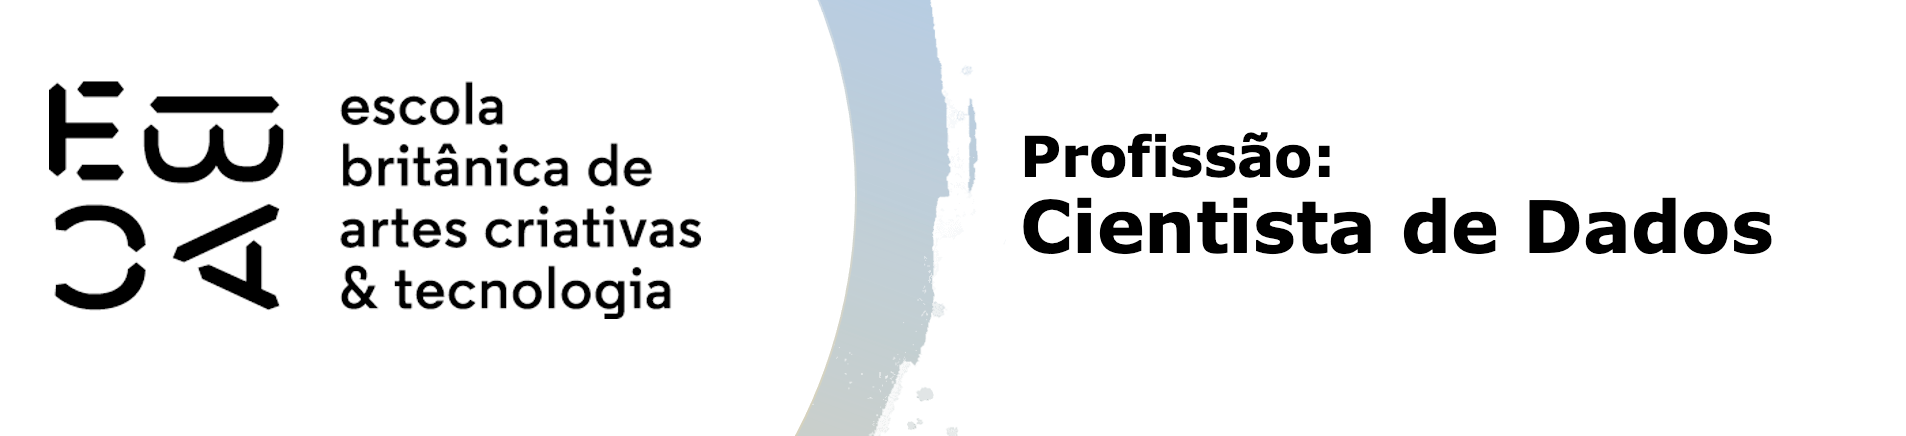

# Tarefa

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?" 

Nosso objetivo é tentar agrupar os clientes conforme seu comportamento de navegação entre páginas administrativas, informativas e de produtos. 

As variáveis estão descritas abaixo (em tradução livre do link indicado).

Por este motivo, o escopo desta análise estará fechado nas primeiras seis variáveis da tabela, referentes a quantidade e tempo de acesso por tipo de página, atributos que falam mais do comportamento de navegação do cliente que de características da página o da época do ano.

|Variavel                |Descrição          | 
|------------------------|:-------------------| 
|Administrative          | Quantidade de acessos em páginas administrativas| 
|Administrative_Duration | Tempo de acesso em páginas administrativas | 
|Informational           | Quantidade de acessos em páginas informativas  | 
|Informational_Duration  | Tempo de acesso em páginas informativas  | 
|ProductRelated          | Quantidade de acessos em páginas de produtos | 
|ProductRelated_Duration | Tempo de acesso em páginas de produtos | 
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  | 
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações | 
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico | 
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) | 
|Month                   | Mês  | 
|OperatingSystems        | Sistema operacional do visitante | 
|Browser                 | Browser do visitante | 
|Region                  | Região | 
|TrafficType             | Tipo de tráfego                  | 
|VisitorType             | Tipo de visitante: novo ou recorrente | 
|Weekend                 | Indica final de semana | 
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
df = pd.read_csv('online_shoppers_intention.csv')

In [3]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
df.Revenue.value_counts(dropna=False)

False    10422
True      1908
Name: Revenue, dtype: int64

## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [5]:
df_0 = df.iloc[:,:6].columns

df[df_0].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
dtypes: float64(3), int64(3)
memory usage: 578.1 KB


In [6]:
df[df_0].describe().T


,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.0000,1.000000,4.000000,27.00000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.0000,7.500000,93.256250,3398.75000
Informational,12330.0,0.503569,1.270156,0.0,0.0000,0.000000,0.000000,24.00000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.0000,0.000000,0.000000,2549.37500
ProductRelated,12330.0,31.731468,44.475503,0.0,7.0000,18.000000,38.000000,705.00000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.1375,598.936905,1464.157214,63973.52223


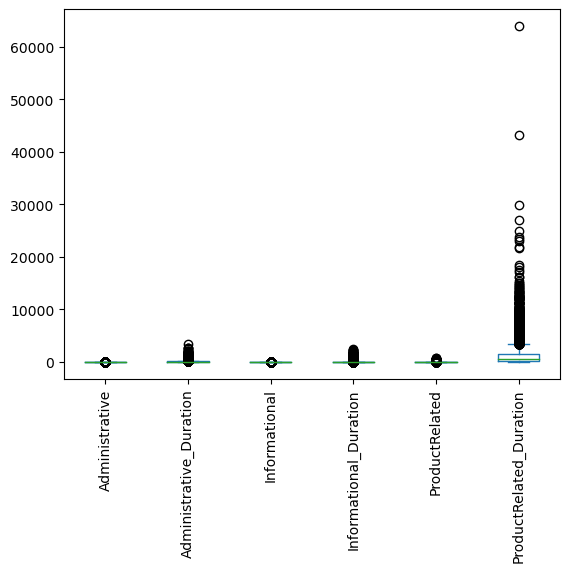

In [7]:
df[df_0].plot.box(rot=90);

In [8]:
df_pad = pd.DataFrame(StandardScaler().fit_transform(df[df_0]), columns=df_0)

df_pad.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  float64
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  float64
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  float64
 5   ProductRelated_Duration  12330 non-null  float64
dtypes: float64(6)
memory usage: 578.1 KB


In [9]:
df_pad.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,-1.375191e-15,1.000041,-0.696993,-0.696993,-0.395938,0.507228,7.431499
Administrative_Duration,12330.0,2.072011e-15,1.000041,-0.457191,-0.457191,-0.414764,0.070360,18.769559
Informational,12330.0,6.987391e-15,1.000041,-0.396478,-0.396478,-0.396478,-0.396478,18.499599
Informational_Duration,12330.0,1.761455e-16,1.000041,-0.244931,-0.244931,-0.244931,-0.244931,17.868683
ProductRelated,12330.0,-2.849753e-16,1.000041,-0.713488,-0.556092,-0.308755,0.140949,15.138577
ProductRelated_Duration,12330.0,9.953199e-16,1.000041,-0.624348,-0.528121,-0.311357,0.140788,32.806777


In [10]:
df_pad.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
dtype: int64

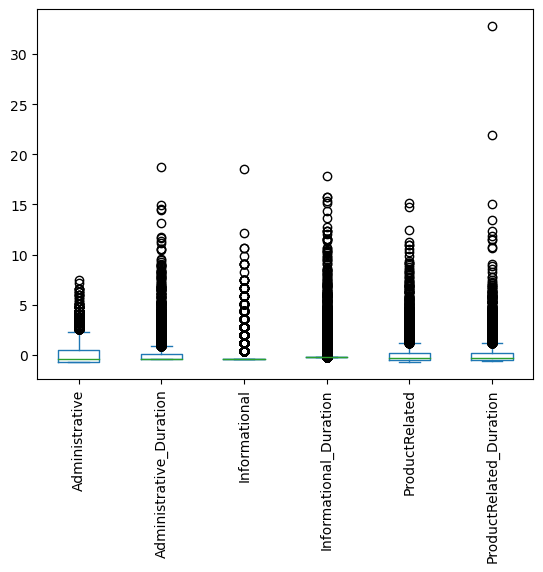

In [11]:
df_pad.plot.box(rot=90);

In [12]:
df_pad['Revenue'] = df.Revenue

df_set = df_pad.groupby('Revenue').median()

df_pad = df_pad.drop(columns=['Revenue'])

col1 = df_set.idxmax(axis=1).values
col1


array(['Informational_Duration', 'ProductRelated_Duration'], dtype=object)

In [13]:
df_pad = df_pad[(df_pad>=-2) & (df_pad<=2)].dropna()

print('''\ndf_pad1 contains {0:.2f}% of original data
------------------------------------------------------
'''.format(100*(df_pad.shape[0]/df.shape[0])))
print(df_pad.describe().T)
      


df_pad1 contains 85.19% of original data
------------------------------------------------------

                           count      mean       std       min       25%  \
Administrative           10504.0 -0.252346  0.629865 -0.696993 -0.696993   
Administrative_Duration  10504.0 -0.218234  0.415587 -0.457191 -0.457191   
Informational            10504.0 -0.225354  0.478467 -0.396478 -0.396478   
Informational_Duration   10504.0 -0.187814  0.229542 -0.244931 -0.244931   
ProductRelated           10504.0 -0.221689  0.491138 -0.713488 -0.578577   
ProductRelated_Duration  10504.0 -0.210296  0.468164 -0.624348 -0.548112   

                              50%       75%       max  
Administrative          -0.696993  0.206173  1.711449  
Administrative_Duration -0.457191 -0.122297  1.992858  
Informational           -0.396478 -0.396478  1.965532  
Informational_Duration  -0.244931 -0.244931  1.986077  
ProductRelated          -0.376210 -0.038932  1.984736  
ProductRelated_Duration -0.377147

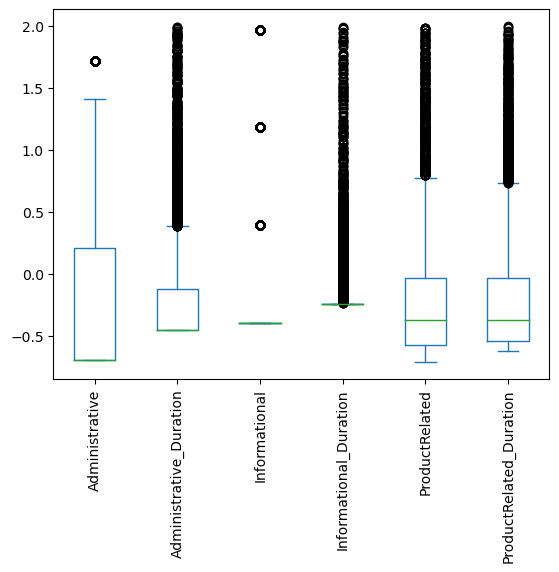

In [14]:
df_pad.plot.box(rot=90);

In [15]:
df_pad['Revenue'] = df.Revenue

df_set = df_pad.groupby('Revenue').median()

df_pad = df_pad.drop(columns=['Revenue'])

col2 = df_set.idxmax(axis=1).values
col2


array(['Informational_Duration', 'ProductRelated_Duration'], dtype=object)

In [16]:
df_ln = df[df_0].copy()
for z in range(df_ln.shape[1]):
    for w in range(df_ln.shape[0]):
        if df_ln.iloc[w,z] != 0:
            df_ln.iloc[w,z] = np.log(df_ln.iloc[w,z])
            
df_ln.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  float64
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  float64
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  float64
 5   ProductRelated_Duration  12330 non-null  float64
dtypes: float64(6)
memory usage: 578.1 KB


In [17]:
df_ln.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,0.623200,0.822235,0.000000,0.000000,0.000000,1.386294,3.295837
Administrative_Duration,12330.0,2.293212,2.361602,0.000000,0.000000,2.014903,4.535351,8.131163
Informational,12330.0,0.138345,0.391244,0.000000,0.000000,0.000000,0.000000,3.178054
Informational_Duration,12330.0,0.837895,1.810153,0.000000,0.000000,0.000000,0.000000,7.843604
ProductRelated,12330.0,2.768683,1.255183,0.000000,1.945910,2.890372,3.637586,6.558198
ProductRelated_Duration,12330.0,5.956863,2.049333,-0.693147,5.215683,6.395156,7.289035,11.066225


In [18]:
df_ln.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
dtype: int64

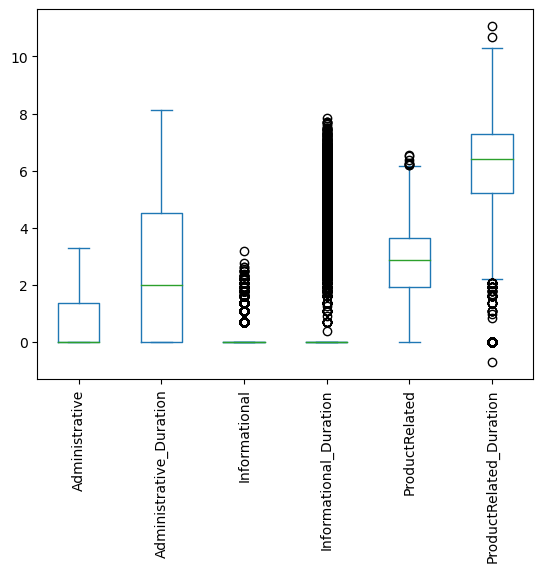

In [19]:
df_ln.plot.box(rot=90);

In [20]:
df_ln['Revenue'] = df.Revenue

df_set = df_ln.groupby('Revenue').median()

df_ln = df_ln.drop(columns=['Revenue'])

col3 = df_set.idxmax(axis=1).values
col3

array(['ProductRelated_Duration', 'ProductRelated_Duration'], dtype=object)

In [21]:
ln_pad = pd.DataFrame(StandardScaler().fit_transform(df_ln), columns=df_0)
ln_pad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  float64
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  float64
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  float64
 5   ProductRelated_Duration  12330 non-null  float64
dtypes: float64(6)
memory usage: 578.1 KB


In [22]:
ln_pad.describe().T

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,-2.767517e-15,1.000041,-0.757964,-0.757964,-0.757964,0.928111,3.250585
Administrative_Duration,12330.0,-1.613416e-15,1.000041,-0.971080,-0.971080,-0.117852,0.949453,2.472130
Informational,12330.0,1.012534e-14,1.000041,-0.353617,-0.353617,-0.353617,-0.353617,7.769668
Informational_Duration,12330.0,8.140285e-16,1.000041,-0.462905,-0.462905,-0.462905,-0.462905,3.870386
ProductRelated,12330.0,-5.358244e-16,1.000041,-2.205890,-0.655527,0.096953,0.692280,3.019216
ProductRelated_Duration,12330.0,1.040764e-15,1.000041,-3.245095,-0.361684,0.213880,0.650078,2.493284


In [23]:
ln_pad.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
dtype: int64

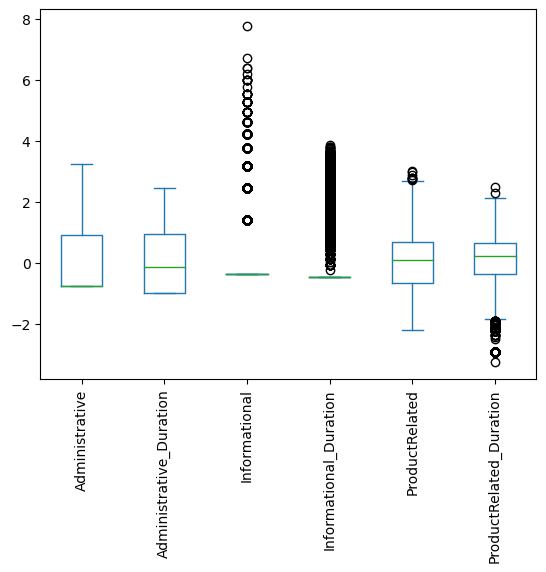

In [24]:
ln_pad.plot.box(rot=90);

In [25]:
ln_pad['Revenue'] = df.Revenue
df_set = ln_pad.groupby('Revenue').median()

ln_pad = ln_pad.drop(columns=['Revenue'])

col4 = df_set.idxmax(axis=1).values
col4



array(['ProductRelated_Duration', 'Administrative_Duration'], dtype=object)

In [26]:
ln_pad = ln_pad[(ln_pad >= -2) & (ln_pad <= ln_pad.quantile(.95)[0])].dropna()

print('''\nln_pad contains {0:.2f}% of original data
------------------------------------------------------------
'''.format(100*(ln_pad.shape[0]/df.shape[0])))

print(ln_pad.describe().T)




ln_pad contains 78.34% of original data
------------------------------------------------------------

                          count      mean       std       min       25%  \
Administrative           9659.0 -0.146917  0.854397 -0.757964 -0.757964   
Administrative_Duration  9659.0 -0.097806  0.944740 -0.971080 -0.971080   
Informational            9659.0 -0.287400  0.336074 -0.353617 -0.353617   
Informational_Duration   9659.0 -0.310186  0.505164 -0.462905 -0.462905   
ProductRelated           9659.0  0.014330  0.789594 -1.653639 -0.549139   
ProductRelated_Duration  9659.0  0.105209  0.642836 -1.957279 -0.296390   

                              50%       75%       max  
Administrative          -0.757964  0.578219  1.914402  
Administrative_Duration -0.971080  0.830995  1.909687  
Informational           -0.353617 -0.353617  1.418106  
Informational_Duration  -0.462905 -0.462905  1.913057  
ProductRelated           0.051413  0.579879  1.913584  
ProductRelated_Duration  0.185991  

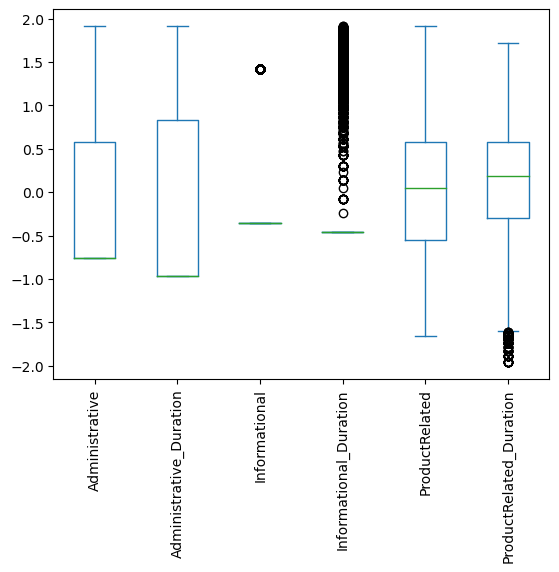

In [27]:
ln_pad.plot.box(rot=90);

In [28]:
ln_pad['Revenue'] = df.Revenue

df_set = ln_pad.groupby('Revenue').median()

ln_pad = ln_pad.drop(columns=['Revenue'])

col5 = df_set.idxmax(axis=1).values
col5


array(['ProductRelated_Duration', 'Administrative_Duration'], dtype=object)

In [29]:
col = list(set(list(col1)+list(col2)+list(col3)+list(col4)+list(col5)))
col

['Administrative_Duration',
 'ProductRelated_Duration',
 'Informational_Duration']

In [30]:
df_pad = df_pad[col]
ln_pad = ln_pad[col]

## Número de grupos

Utilize as técnicas vistas em aula que te ajudem a decidir pelo número de grupos a ser utilizados.

In [31]:
def sqd(df,variaveis):
    SQD = []
    K = range(1,15)
    for k in tqdm(K):
        km = KMeans(n_clusters=k)
        km = km.fit(df[variaveis])
        SQD.append(km.inertia_)
    
    o = pd.DataFrame({'num_clusters': list(range(1, len(SQD)+1)), 'SQD': SQD})
    
    return o

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

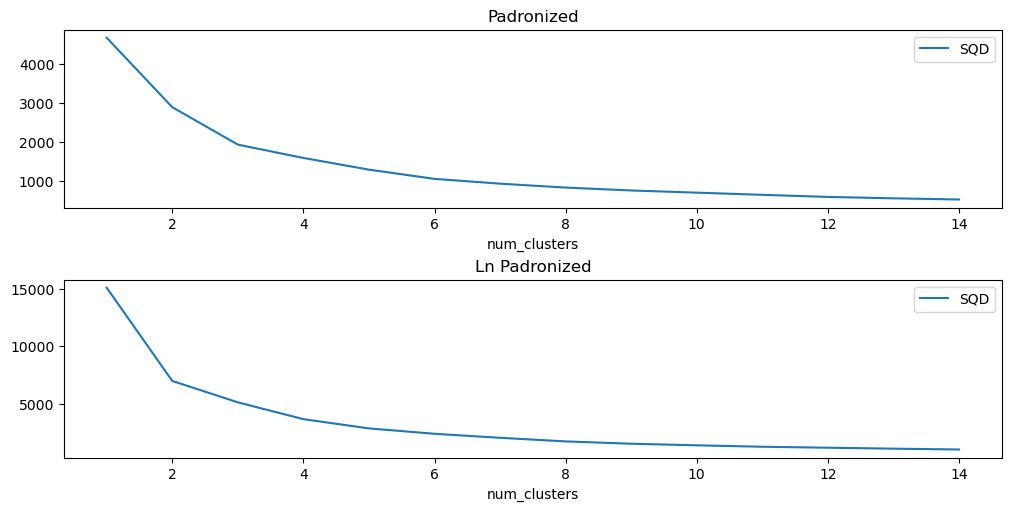

In [32]:
fig , ax = plt.subplots(2, figsize=(10,5), layout='constrained')

variaveis = col

o1 = sqd(df_pad,variaveis)

o2 = sqd(ln_pad,variaveis)


o1.plot(ax = ax[0], x = 'num_clusters', y = 'SQD', title='Padronized');
o2.plot(ax = ax[1], x = 'num_clusters', y = 'SQD', title='Ln Padronized');



In [33]:
def silhouet(df,variaveis):

    # Inicializar uma lista vazia que vai conter os valores da silueta média
    siluetas = []
    # Este é o número máximo de grupos que vamos testar
    max_clusters = 10

    # O loop percorre de 2 até o máximo de clusters
    for n_clusters in tqdm(range(2, max_clusters+1)):
        # Aqui rodamos o k-means
        km = KMeans(n_clusters=n_clusters).fit(df[variaveis])
        # Aqui calculamos a silueta e guardamos o resultado na lista 'siluetas'
        siluetas.append(silhouette_score(df[variaveis], km.labels_))
        # Essa list comprehendion define o nome dos grupos
        nomes_grupos = ['grupo_' + str(g) for g in range(n_clusters)]
        # Agora vamos adicionar uma coluna no dataframe X_pad com o agrupamento construido
        df['grupos_'+str(n_clusters)] = pd.Categorical.from_codes(km.labels_, categories = nomes_grupos)

        
    return [df, siluetas]


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

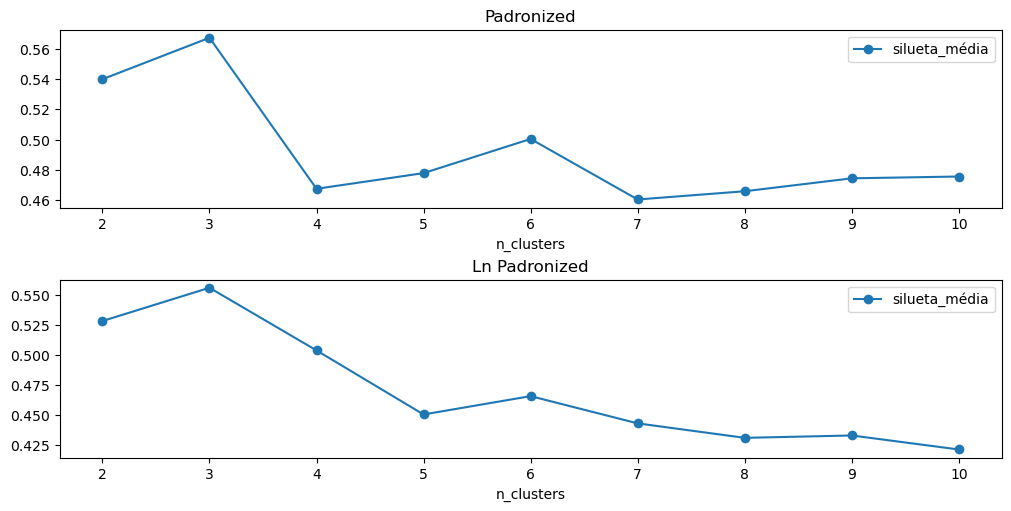

In [34]:

df_pad = silhouet(df_pad,variaveis)

ln_pad = silhouet(ln_pad,variaveis)


fig , ax = plt.subplots(2, figsize=(10,5), layout='constrained')

o1 = pd.DataFrame({'n_clusters': list(range(2, 11)), 'silueta_média': df_pad[1]})
o2 = pd.DataFrame({'n_clusters': list(range(2, 11)), 'silueta_média': ln_pad[1]})

o1.plot.line(ax= ax[0], x = 'n_clusters', y = 'silueta_média', marker='o', title = 'Padronized');
o2.plot.line(ax= ax[1], x = 'n_clusters', y = 'silueta_média', marker='o', title = 'Ln Padronized');


df_pad = df_pad[0]

ln_pad = ln_pad[0]



In [35]:

pad_2 = df_pad.drop(columns=['grupos_3','grupos_4','grupos_5','grupos_6','grupos_7','grupos_8','grupos_9','grupos_10'])
pad_3 = df_pad.drop(columns=['grupos_2','grupos_4','grupos_5','grupos_6','grupos_7','grupos_8','grupos_9','grupos_10'])

ln_2 = ln_pad.drop(columns=['grupos_3','grupos_4','grupos_5','grupos_6','grupos_7','grupos_8','grupos_9','grupos_10'])
ln_3 = ln_pad.drop(columns=['grupos_2','grupos_4','grupos_5','grupos_6','grupos_7','grupos_8','grupos_9','grupos_10'])



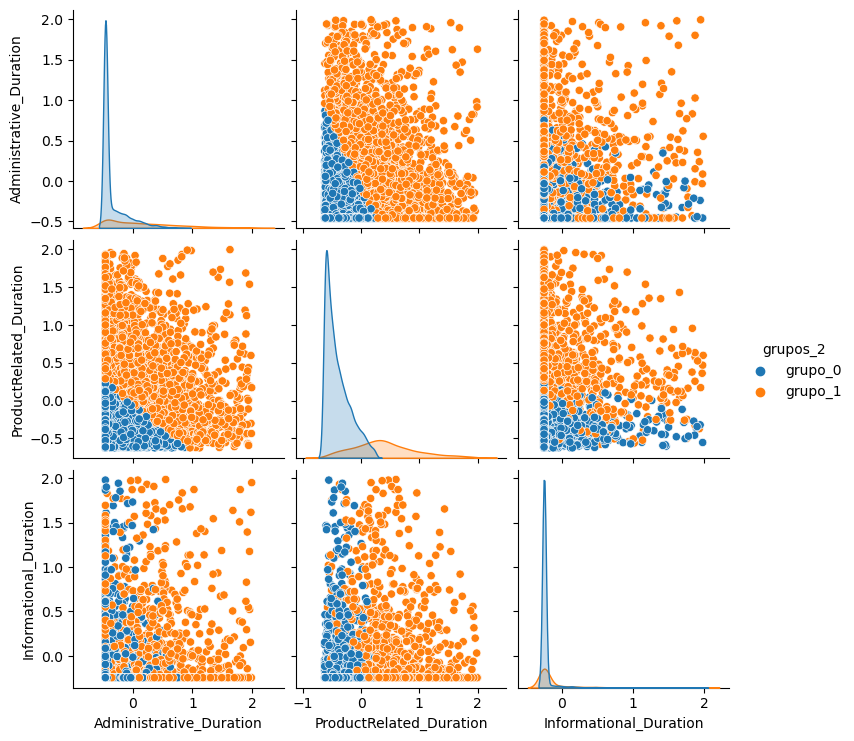

In [36]:
sns.pairplot(pad_2,hue='grupos_2');

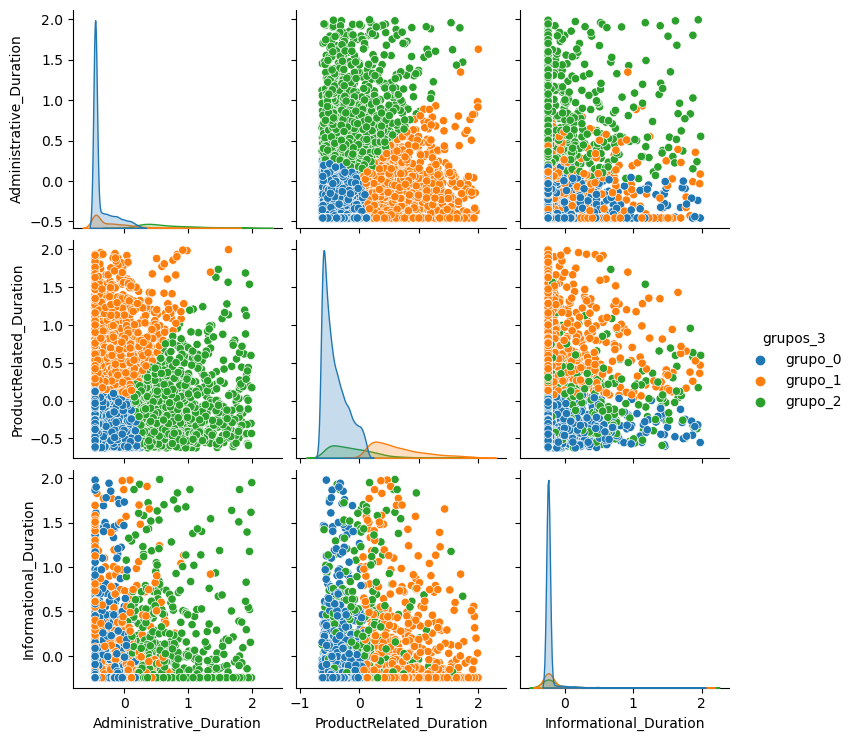

In [37]:
sns.pairplot(pad_3,hue='grupos_3');

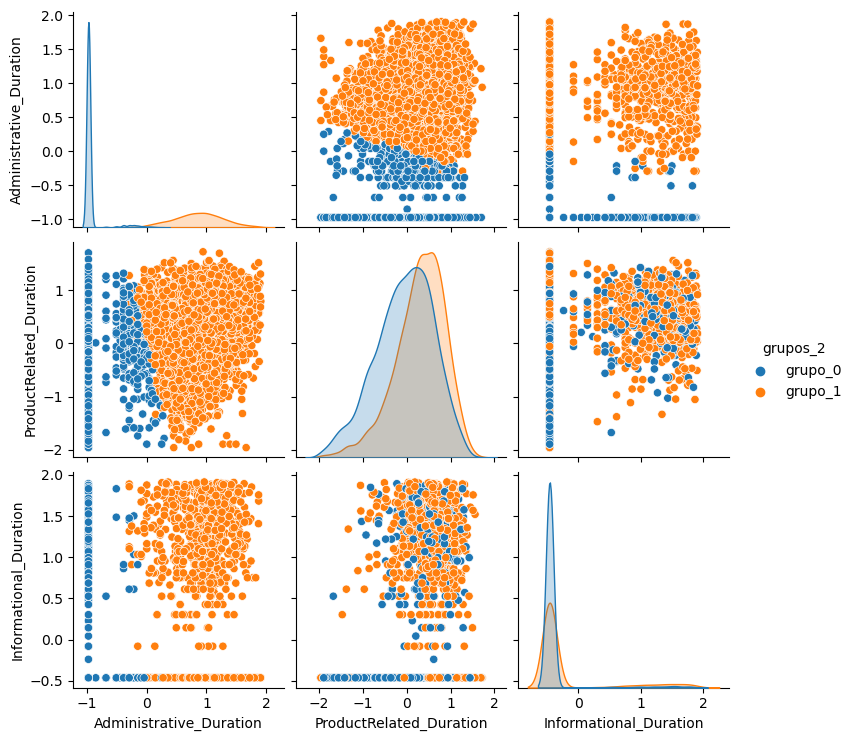

In [38]:
sns.pairplot(ln_2,hue='grupos_2');

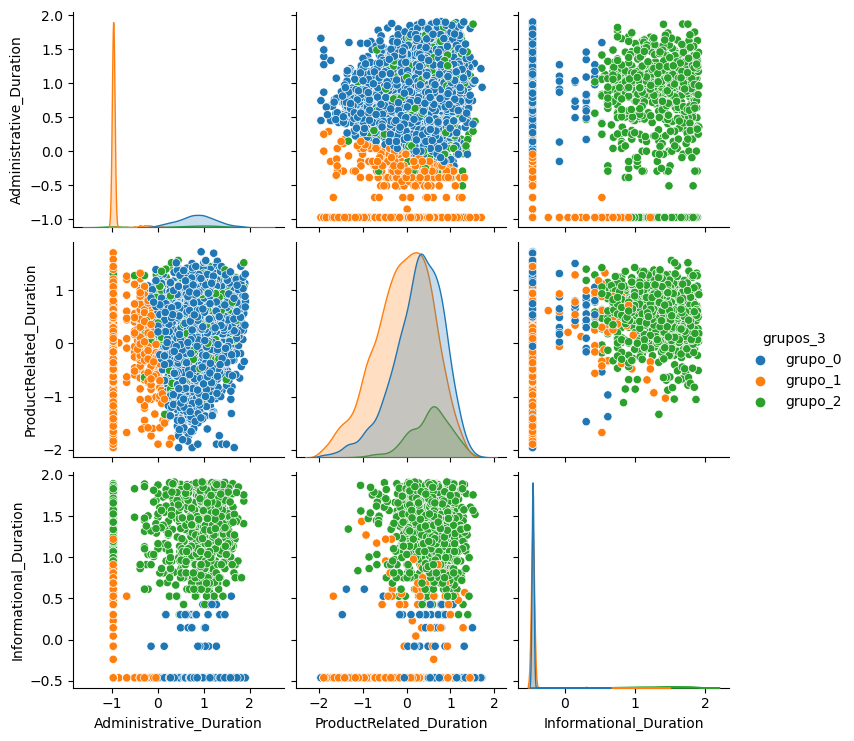

In [39]:
sns.pairplot(ln_3,hue='grupos_3');

## Avaliação dos grupos

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final. 
- Se puder, sugira nomes para os grupos.

In [40]:
pad_3

,Administrative_Duration,ProductRelated_Duration,Informational_Duration,grupos_3
0,-0.457191,-0.624348,-0.244931,grupo_0
1,-0.457191,-0.590903,-0.244931,grupo_0
2,-0.457191,-0.624348,-0.244931,grupo_0
3,-0.457191,-0.622954,-0.244931,grupo_0
4,-0.457191,-0.296430,-0.244931,grupo_0
...,...,...,...,...
12325,0.363075,0.307822,-0.244931,grupo_2
12326,-0.457191,-0.380957,-0.244931,grupo_0
12327,-0.457191,-0.528063,-0.244931,grupo_0
12328,-0.032916,-0.443536,-0.244931,grupo_0


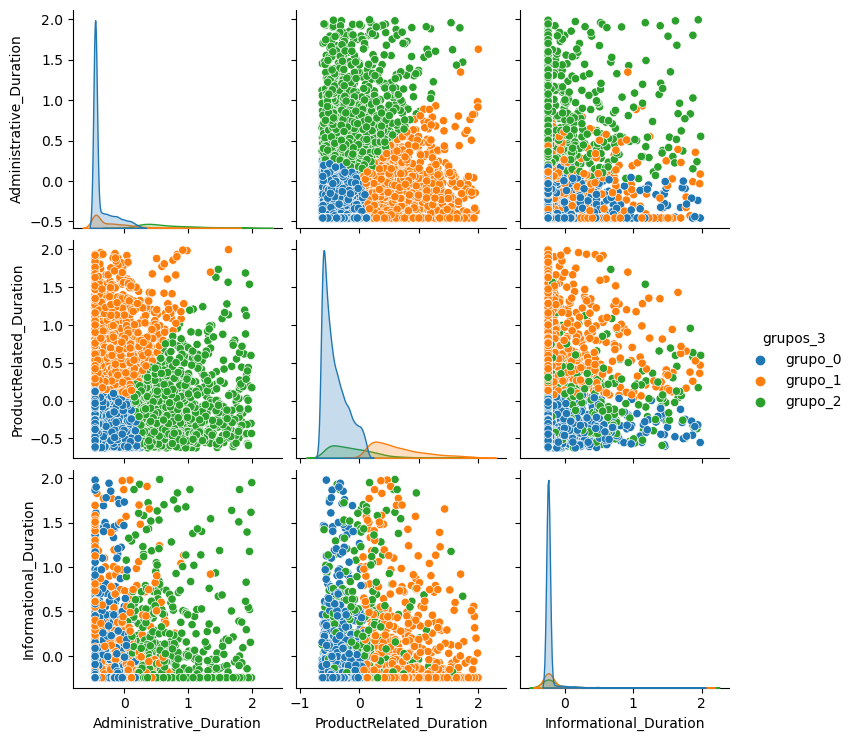

In [41]:
sns.pairplot(pad_3,hue='grupos_3');

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*). 
- Qual grupo possui clientes mais propensos à compra?

In [50]:
pad_3.groupby(['grupos_3']).describe().T

grupos_3                           grupo_0      grupo_1      grupo_2
Administrative_Duration count  7630.000000  1644.000000  1230.000000
                        mean     -0.364726    -0.229276     0.705252
                        std       0.167077     0.284996     0.455212
                        min      -0.457191    -0.457191    -0.008402
                        25%      -0.457191    -0.457191     0.352279
                        50%      -0.457191    -0.342920     0.562578
                        75%      -0.332737    -0.069376     0.968112
                        max       0.258420     1.629301     1.992858
ProductRelated_Duration count  7630.000000  1644.000000  1230.000000
                        mean     -0.408962     0.642995    -0.118415
                        std       0.200102     0.438641     0.373983
                        min      -0.624348     0.030616    -0.624348
                        25%      -0.578361     0.285463    -0.413771
                        50%      -0.469313     0.525190    -0.190492
                        75%      -0.281776     0.879844     0.098872
                        max       0.139574     1.997085     1.735920
Informational_Duration  count  7630.000000  1644.000000  1230.000000
                        mean     -0.215832    -0.131844    -0.088821
                        std       0.157185     0.316256     0.379914
                        min      -0.244931    -0.244931    -0.244931
                        25%      -0.244931    -0.244931    -0.244931
                        50%      -0.244931    -0.244931    -0.244931
                        75%      -0.244931    -0.244931    -0.180984
                        max       1.978972     1.978972     1.986077

In [49]:
pad_3.join(df.Revenue, on= pad_3.index, how='left').groupby(['grupos_3','Revenue'])['Revenue'].sum()

grupos_3  Revenue
grupo_0   False        0
          True       866
grupo_1   False        0
          True       330
grupo_2   False        0
          True       236
Name: Revenue, dtype: int64

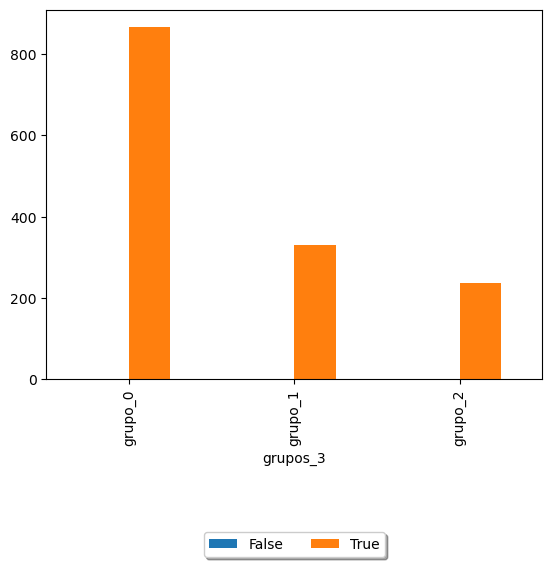

In [43]:
ax = pad_3.join(df.Revenue, on= pad_3.index, how='left').groupby(['grupos_3', 'Revenue'])['Revenue'].sum().unstack().plot.bar()

ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.5),
          ncol=3, fancybox=True, shadow=True);

